In [49]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import torch
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [50]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [51]:
reviewdf= pd.read_csv("/content/drive/MyDrive/video_game_reviews.csv")

In [52]:
reviewdf['review'] = reviewdf['review'].astype(str)

In [53]:
reviewdf['word_count'] = reviewdf['review'].str.split().str.len()
reviewdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26652 entries, 0 to 26651
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26652 non-null  int64 
 1   review         26652 non-null  object
 2   review_rating  26652 non-null  int64 
 3   word_count     26652 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 833.0+ KB


In [7]:
!pip install -U transformers

In [54]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")



In [55]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=False
)

In [56]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model.eval()

MAX_LENGTH = 510

def distilled_student_sentiment_classifier(text):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i + MAX_LENGTH] for i in range(0, len(tokens), MAX_LENGTH)]

    outputs = []
    with torch.no_grad():
        for chunk in chunks:
            input_ids = torch.tensor([tokenizer.build_inputs_with_special_tokens(chunk)])
            logits = model(input_ids).logits
            outputs.append(logits)

    # Average score
    final_logits = torch.mean(torch.stack(outputs), dim=0)
    prediction_id = torch.argmax(final_logits, dim=1).item()
    label = model.config.id2label[prediction_id]

    return label


In [12]:
distilled_student_sentiment_classifier(
    [
        "Three Rings for the Elven-kings under the sky, Seven for the Dwarf-lords in their halls of stone",
        "Nine for Mortal Men, doomed to die, One for the Dark Lord on his dark throne",
    ])

'negative'

In [58]:
reviewdf['sentiment'] = reviewdf['review'].apply(distilled_student_sentiment_classifier)


In [59]:
reviewdf.head()

,id,review,review_rating,word_count,sentiment
0,1,1st shipment received a book instead of the ga...,1,53,positive
1,2,I still haven't figured this one out. Did ever...,2,80,negative
2,3,I bought this and the key didn't work. It was...,1,37,negative
3,4,I love it! Use it all the time. Really works p...,5,20,positive
4,5,my grandkids (and their parents) love playing ...,5,37,positive


In [60]:
reviewdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26652 entries, 0 to 26651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26652 non-null  int64 
 1   review         26652 non-null  object
 2   review_rating  26652 non-null  int64 
 3   word_count     26652 non-null  int64 
 4   sentiment      26652 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.0+ MB


In [61]:
# Save DataFrame to CSV file
reviewdf.to_csv("full_reviews_dataset.csv", index=False)


In [62]:
from google.colab import files
files.download("full_reviews_dataset.csv")  # or .csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

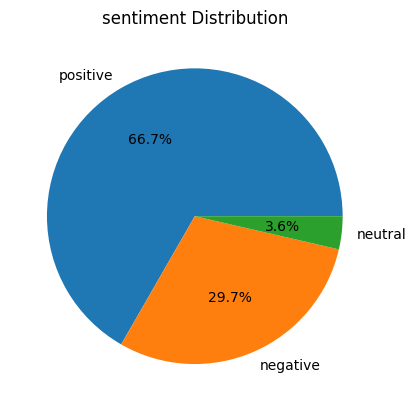

In [63]:
plt.pie(reviewdf['sentiment'].value_counts().values,
        labels=reviewdf['sentiment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("sentiment Distribution")
plt.show()
#og dataset distirinbution

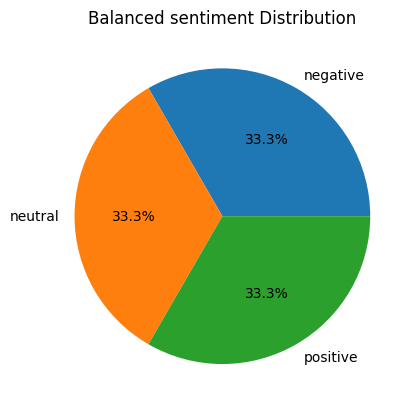

In [64]:
star1 = reviewdf[reviewdf['sentiment'] == "negative"].sample(n=700, random_state=42)
star2 = reviewdf[reviewdf['sentiment'] == "neutral"].sample(n=700, random_state=42)
star3 = reviewdf[reviewdf['sentiment'] == "positive"].sample(n=700, random_state=42)

balanced_df = pd.concat([star1, star2, star3], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['sentiment'].value_counts().values,
        labels=balanced_df['sentiment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced sentiment Distribution")
plt.show()

In [65]:

import string
reviewdf['review'] = reviewdf['review'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

reviewdf['review']= reviewdf['review'].apply(lambda x: remove_punctuations(x))
reviewdf.head()

,id,review,review_rating,word_count,sentiment
0,1,1st shipment received a book instead of the ga...,1,53,positive
1,2,i still havent figured this one out did everyt...,2,80,negative
2,3,i bought this and the key didnt work it was a...,1,37,negative
3,4,i love it use it all the time really works per...,5,20,positive
4,5,my grandkids and their parents love playing wi...,5,37,positive


In [66]:
balanced_df.head()

,id,review,review_rating,word_count,sentiment
7693,7694,Gotta pay to play online I guess. Do I like pa...,3,68,negative
25863,25864,I wish i could return this. It's an amazing p...,3,476,negative
14233,14234,I haven't has this much fun playing a game in ...,5,105,negative
26088,26089,So I've played the game for about 3-4 hours no...,4,746,negative
10945,10946,This game looks like it was suppose to be main...,2,131,negative


In [67]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['review'] = balanced_df['review'].apply(preprocess_text)

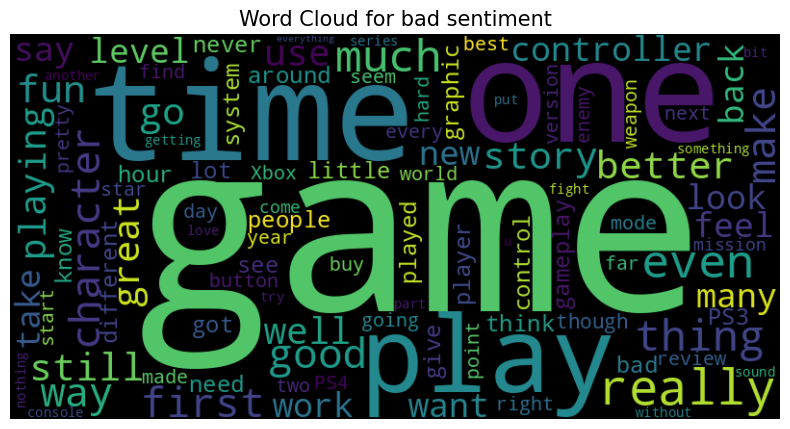

In [68]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['review'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} sentiment", fontsize=15)
    plt.show()

plot_word_cloud(balanced_df[balanced_df['sentiment'] == "negative"], typ="bad")

In [69]:
features = balanced_df['review']
target = balanced_df['sentiment']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [74]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100
#model overfitting very badly for now, going to fix over weekend
model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [82]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [83]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9881 - loss: 0.1509 - val_accuracy: 0.4976 - val_loss: 1.1005 - learning_rate: 5.0000e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9953 - loss: 0.1034 - val_accuracy: 0.5262 - val_loss: 1.0988 - learning_rate: 5.0000e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9923 - loss: 0.1039 - val_accuracy: 0.5310 - val_loss: 1.1221 - learning_rate: 5.0000e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9945 - loss: 0.0900 - val_accuracy: 0.5000 - val_loss: 1.2926 - learning_rate: 5.0000e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9973 - loss: 0.0786 - val_accuracy: 0.5381 - val_loss: 1.3635 - learning_rate: 2.5000e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9982 - loss: 0.0661 - val_accuracy: 0.5476 - val_loss: 1.5095 - learning_rate: 2.5000e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9976 

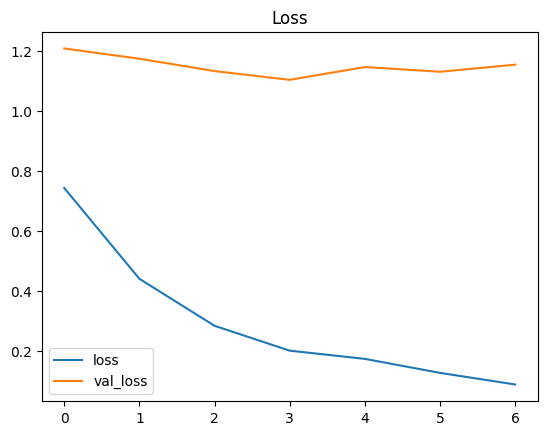

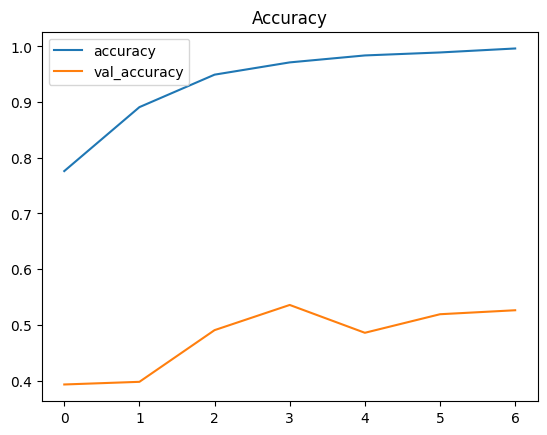

In [78]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [81]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5339 - loss: 1.1049
Validation Accuracy: 0.54


Sort rating into helpful or harmful, id phrases  and tone